<a href="https://www.kaggle.com/code/yannicksteph/cnn-cv-rice-classification?scriptVersionId=139405231" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classification of Rice Types using Convolutional Neural Networks (CNNs)
# <b>1 <span style='color:#78D118'>|</span> Introduction</b>

This notebook focuses on building a classification model using Convolutional Neural Networks (CNNs) to identify different types of rice from images. The dataset comprises 15,000 images for each of the five rice categories: Arborio, Basmati, Ipsala, Jasmine, and Karacadag.

## Dataset Overview
The dataset consists of images representing five distinct types of rice:

- Arborio
- Basmati
- Ipsala
- Jasmine
- Karacadag

## Objectives
- The primary objective of this notebook is to train a CNN model that achieves high accuracy in classifying different types of rice based on the provided images.
- Play with preprocessing layers.
- Play with data loading performance optimizers.

## Implementation
To achieve the aforementioned objectives, we will follow these steps:

- **Imports, Constants:** Importing the necessary libraries, defining constants, and creating methods essential for our task.
- **Data Retrieval:** Obtaining the rice types dataset required for training and evaluation.
- **Data Preparation:** Preprocessing and organizing the dataset to ensure effective training of the CNN model.
- **Model Creation:** Designing and building the CNN model using the Keras framework.
- **Model Training:** Training the CNN model using the prepared rice types dataset.
- **Evaluation:** Assessing the performance of the trained model and analyzing its classification results.

By following these steps, we aim to develop a robust CNN model capable of accurately classifying different types of rice based on their images.



# <b>2 <span style='color:#78D118'>|</span> Imports & Constants and Methods</b>



## <b>2.1 <span style='color:#78D118'>|</span> Imports</b>

In [1]:
!pip install -q visualkeras
!pip install -q git+https://github.com/YanSteph/SKit.git@0.1.3

In [2]:
# Standard library imports
import os
import time
import sys
import math
import glob
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.image as img

# Deep learning and machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model

# Model visual
from visualkeras import layered_view

# Skit
from skit.utils import ls, mkdir, count_files
from skit.show import show_text, show_images, show_donut, show_history, show_confusion_matrix, tf_show_images
from skit.image import average_image_size
from skit.dataset import split_images_dataset, tf_shuffle_dataset
from skit.ModelMetrics import ModelMetrics
from skit.prediction import tf_predictions, tf_wrong_predictions

## <b>2.3 <span style='color:#78D118'>|</span> Constants</b>



To customize the dataset generation, you have the option to perform tests or generate the entire enhanced dataset by adjusting the following parameters:


- `models`: This is a dictionary of model getter function names keyed by their identifiers.
- `seed`: This is the random seed used to ensure reproducibility of the experiments.
- `batch_size`: The number of training examples utilized in one iteration.
- `epochs`: An epoch is a measure of the number of times all of the training vectors are used once to update the weights.
- `shuffle`: This boolean value indicates whether the dataset should be shuffled before each epoch.
- `with_datagen`: This boolean value specifies whether to use a data generator for data augmentation.
- `image_resize`: This tuple specifies the dimensions to which each image in the dataset will be resized before being fed into the model.
- `verbosity`: This value specifies the level of output detail during training.
  - 0: Silent mode, no output will be displayed during training.
  - 1: Progress bar mode, a progress bar will be displayed to show the progress of each epoch.
  - 2: One line per epoch mode, a concise summary will be displayed for each epoch. In this run, the verbosity is set to 2.

**Dataset Partition**:
- `train_dataset_ratio`: This value specifies the proportion of the dataset to use for training. In this run, 70% of the dataset is used for training.
- `validation_dataset_ratio`: This value specifies the proportion of the dataset to use for validation. In this run, 15% of the dataset is designated for validation.
- `test_dataset_ratio`: This value specifies the proportion of the dataset to use for testing. In this run, 15% of the dataset is used for testing.

In [3]:
# ---------------- #
# Configuration
# ---------------- #

# Test
# -----
# models        = {'v1':'get_model_v1'}
# seed          = 123
# batch_size    = 128
# epochs        = 1
# shuffle       = False
# with_datagen  = False
# image_resize  = (32, 32) # 32x32, 64x64, 96x96, 128x128, 224x224, 299x299, et 512x512
# verbosity = 2
# Dataset partision
# train_dataset_ratio = 0.01
# validation_dataset_ratio = 0.01
# test_dataset_ratio = 0.01


# Test 2
# Accurancy = 97%
# -----
# models        = {'v2':'model_v2', 'v3':'model_v3'}
# seed          = 123
# batch_size    = 20
# epochs        = 20
# shuffle       = True
# with_datagen  = True
# image_resize  = (128, 128)
# verbosity = 2
# Dataset partision
# train_dataset_ratio = 0.7
# validation_dataset_ratio = 0.15
# test_dataset_ratio = 0.15

# Best
# Accurancy = 99%
# -----
models = { 'v4':'model_v4' }
seed          = 123
batch_size    = 4
epochs        = 20
shuffle       = True
with_datagen  = True
image_resize  = None
verbosity     = 2

# Dataset partision
train_dataset_ratio      = 0.7
validation_dataset_ratio = 0.15
test_dataset_ratio       = 0.15

In [4]:
# ---------------- #
# Global dynamic
# ---------------- #
labels = None
image_shape = None
preprocessings_layers = None

In [5]:
# ---------------- #
# Patch
# ---------------- #

# Dataset
# -----
# Dataset Directory
dataset_dir = "../input/rice-image-dataset/Rice_Image_Dataset"

# Run
# -----
# ./run
run_dir = './run'

# Run Dataset
# ----
run_dataset_dir = f"{run_dir}/Dataset"
run_ds_train_dir = f'{run_dataset_dir}/train/'
run_ds_validation_dir = f'{run_dataset_dir}/validation/'
run_ds_test_dir = f'{run_dataset_dir}/test/'

# TF Callback
# ----
logs_path = f'{run_dir}/logs'
best_model_path = f'{run_dir}/models'

# <b>3 <span style='color:#78D118'>|</span> Data Exploration</b>

In this section, we will delve into understanding the 5 distinct classes that our images fall into. These classes represent different types of rice, and each class is denoted by a unique class ID. Gaining a clear understanding of these categories will assist us in later stages of model training and prediction.

The dataset consists of images representing five distinct types of rice:

In [6]:
labels = ls(dataset_dir, "dir")
show_text("b", labels)

**['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']**

In [7]:
avg_width, avg_height, avg_channels = average_image_size(dataset_dir)

image_shape = (int(avg_width-1), int(avg_height-1), int(avg_channels))

show_text("b", f'Average Width: {avg_width}', False)
show_text("b", f'Average Height: {avg_height}', False)
show_text("b", f'Average Channels: {avg_channels}', False)

Calculate the average images shape: 100%|██████████| 75000/75000 [01:16<00:00, 975.61file/s] 


**Average Width: 250.0**

**Average Height: 250.0**

**Average Channels: 3.0**

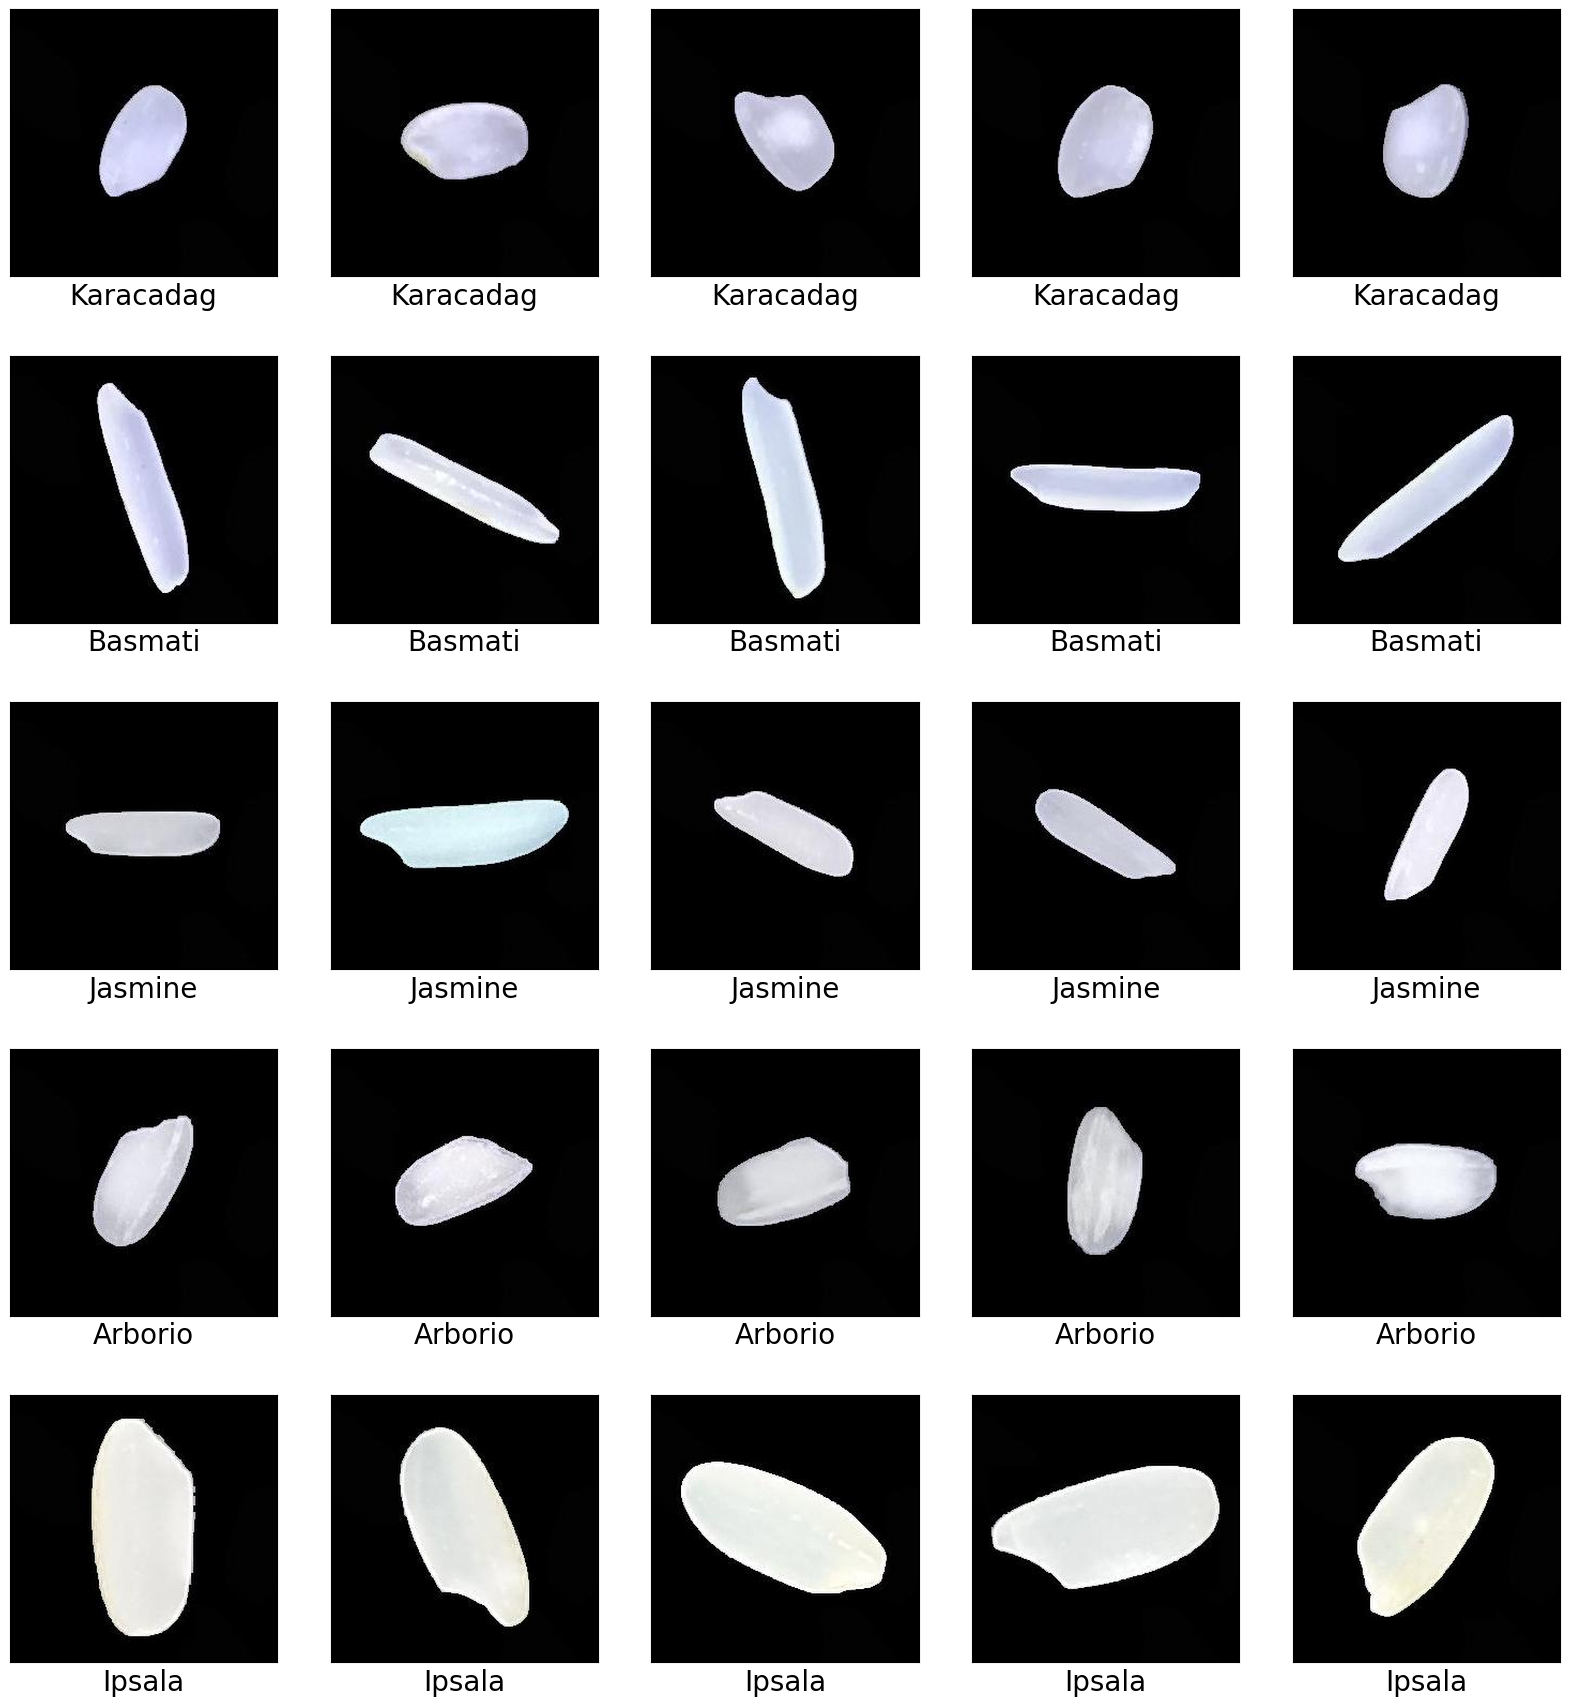

In [8]:
rice_files = {rice_type: list(Path(dataset_dir).glob(f'{rice_type}/*'))[:5] for rice_type in labels}

# lecture des images dans un tableau numpy
x = [img.imread(file) for rice_files in rice_files.values() for file in rice_files]
y = [rice_type for rice_type in labels for _ in range(5)]  # répéter chaque nom de riz 5 fois

show_images(x, y, columns=len(labels), figure_size=(4, 4))

# <b>4 <span style='color:#78D118'>|</span> Data Preparation</b>

In this step, we will be loading the following subsets of our dataset:

* **Training**: This is the training set, which is used to train the model. The model learns from this data.
* **Validation**: This is the validation set, used to evaluate the model's performance during training. This dataset is used to adjust the model's parameters and to prevent overfitting.
* **Test**: This is the test set, used to evaluate the final performance of the model after training. This dataset is used to get an unbiased evaluation of how the model performs on unseen data.

## <b>4.1 <span style='color:#78D118'>|</span> Data Split Train, Test, Validation</b>

In [9]:
split_images_dataset(
    dataset_dir,
    run_dataset_dir,
    labels,
    train_ratio=train_dataset_ratio,
    validation_ratio=validation_dataset_ratio,
    test_ratio=test_dataset_ratio,
    shuffle_data=True,
    seed=seed
)

Spliting into train, validation and test sets: 100%|██████████| 75000/75000 [00:59<00:00, 1256.95file/s]


Counting files: 100%|██████████| 11255/11255 [00:01<00:00, 9130.32dir/s]


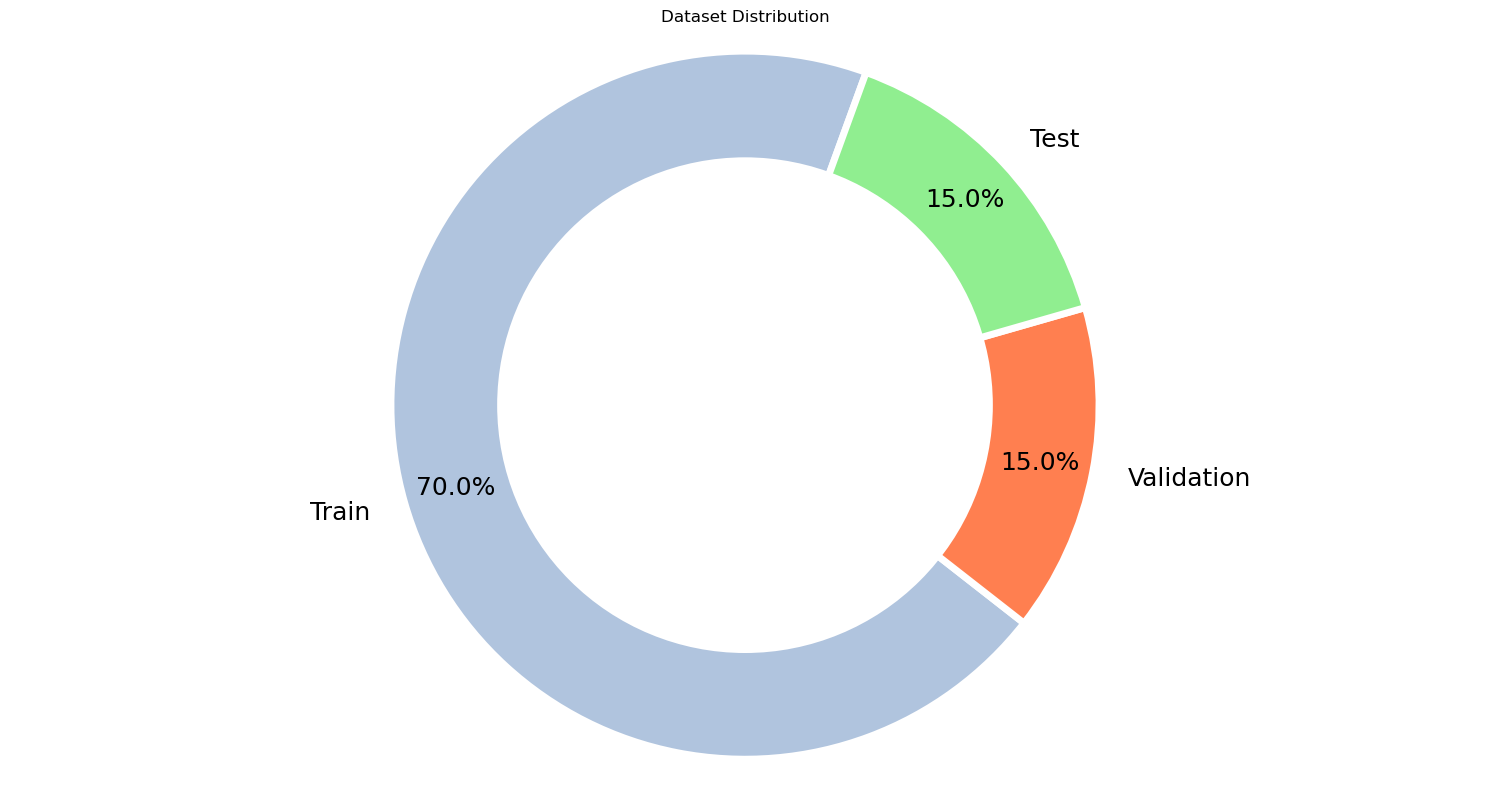

In [10]:
image_counts = [sum(count_files(dir, ".jpg").values()) for dir in [run_ds_train_dir, run_ds_validation_dir, run_ds_test_dir]]

show_donut(
    image_counts,
    ["Train", "Validation", "Test"],
    colors = ["lightsteelblue","coral","lightgreen"],
    figsize = (15,8),
    title = "Dataset Distribution"
)

## <b>4.2 <span style='color:#78D118'>|</span> Data Train, Test, Validation</b>

In [11]:
# Shape img
# ----
img_width, img_height, channel = image_shape

# Definition
# ----
color_mode = 'rgb'
label_mode = 'categorical'

# Train
# ----
train_ds = image_dataset_from_directory(
    directory  = run_ds_train_dir,
    shuffle    = shuffle,
    seed       = seed,
    color_mode = color_mode,
    image_size = (img_width, img_height),
    batch_size = batch_size,
    label_mode = label_mode
)

# Validation
# ----
val_ds = image_dataset_from_directory(
    directory  = run_ds_validation_dir,
    shuffle    = False,
    color_mode = color_mode,
    image_size = (img_width, img_height),
    batch_size = batch_size,
    label_mode = label_mode
)

# Test
# ----
test_ds = image_dataset_from_directory(
    directory  = run_ds_test_dir,
    shuffle    = False,
    color_mode = color_mode,
    image_size = (img_width, img_height),
    batch_size = batch_size,
    label_mode = label_mode
)

Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


# <b>5 <span style='color:#78D118'>|</span> Data Preprocessing</b>

In this section, we focus on preparing and transforming our data for the machine learning process.

**Note:**
1.  Preprocessing layers like `resize_and_rescale` are included in the model.
2.  `data_augmentation` is activated only during training, not during evaluation or prediction.
3.  Preprocessing layers are saved with the model.
4.  Preprocessings are automatically applied when using the model later.
5.  This simplifies the deployment of the model as there's no need to reimplement preprocessing logic server-side.

## <b>5.1 <span style='color:#78D118'>|</span> Resizing and Rescaling</b>

- **Rescaling**
    - **Normalization:** The pixel values of the images should be normalized to fall within a specific range, typically between 0 and 1. This aids in speeding up the training process and achieving better performance.

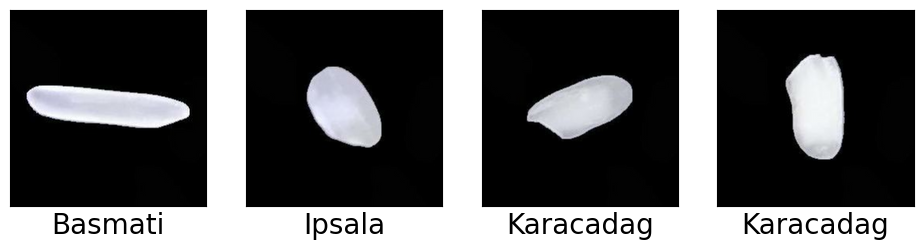

In [12]:
# Reset
preprocessings_layers = []

# Get sizes
input_shape = image_shape

rescale_preprocessing = Sequential([
    Rescaling(1./255, input_shape = input_shape)
])

train_preview_ds = train_ds.take(1)
train_preview_ds = train_preview_ds.map(lambda x, y: (rescale_preprocessing(x), y))

tf_show_images(train_preview_ds, labels)

preprocessings_layers.append(rescale_preprocessing)

## <b>5.2 <span style='color:#78D118'>|</span> Augmentation</b>

- **Augmentation**
    - **RandomFlip:** Randomly flips the images both horizontally and vertically.
    - **RandomRotation:** Randomly rotates the images.


- **Note**:
    - **RandomZoom:** I made an error by adding the zoom functionality, which caused discrepancies between the test data and the validation set.
   

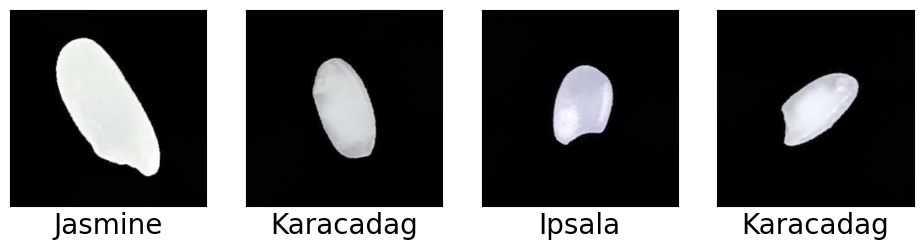

In [13]:
if with_datagen:
    transformation_preprocessing = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.3),
    ])

    train_preview_ds = train_preview_ds.map(lambda x, y: (transformation_preprocessing(x), y))

    tf_show_images(train_preview_ds, labels)

    preprocessings_layers.append(transformation_preprocessing)

## <b>5.3 <span style='color:#78D118'>|</span> Loading Optimization</b>


- **Loading Optimization**
  - Use Autotuning for Data Loading: The `AUTOTUNE` parameter in TensorFlow's `tf.data` module adjusts the prefetch buffer size dynamically based on system resources, optimizing data loading performance during training.
  - Shuffle and Prefetch Training Data: Shuffling the training data with a window size of N elements introduces randomness, prevents memorization of the sample order, and promotes better generalization.
  - No Cache Usage: The `cache()` method is not used here because it might lead to high memory usage when dealing with large datasets. Since the dataset is shuffled, the entire dataset need not be cached, making it more memory-efficient. And I'm limited with memory. :)  

In [14]:
#Set buffer size for data prefetching. Larger buffer size can improve performance.
buffer_size = tf.data.AUTOTUNE

# Preload training and validation data using prefetch for faster execution.
train_ds = train_ds.shuffle(500, seed=seed).prefetch(buffer_size=buffer_size)
val_ds = val_ds.prefetch(buffer_size=buffer_size)

# <b>6 <span style='color:#78D118'>|</span> Model Creation</b>

In [15]:
def apply_preprocessing(model, preprocessings):
    for preprocessing in preprocessings:
        model.add(preprocessing)
    return model

# Test
#
def model_v1(lx,ly,lz, preprocessings):

    model = Sequential() #Creating Neural Network

    model = apply_preprocessing(model, preprocessings)

    image_resize_width, image_resize_height = image_resize

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(image_resize_width, image_resize_height, lz))) #Adding Conv Layer
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) #Adding Conv Layer
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2)) #Adding Pooling Layer

    model.add(Conv2D(filters=48, kernel_size=3, activation='relu')) #Adding Conv Layer
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2)) #Adding Pooling Layer

    model.add(Flatten()) #Flattening
    model.add(Dense(units=lx, activation='tanh')) #Adding Full Connection Layer
    model.add(Dropout(0.25))
    model.add(Dense(units=5, activation='softmax')) #Adding Output Layer

    return model

# A more sophisticated model
# ----
def model_v2(lx, ly, lz, preprocessings):
    model = Sequential()

    model = apply_preprocessing(model, preprocessings)

    w, h, channel = image_shape
    image_resize_width, image_resize_height = image_resize

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(image_resize_width, image_resize_height, lz), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(units=5, activation='softmax'))

    return model


# A more sophisticated model
# Add more Normalization
def model_v3(lx, ly, lz, preprocessings):
    model = Sequential()

    model = apply_preprocessing(model, preprocessings)

    w, h, channel = image_shape
    image_resize_width, image_resize_height = image_resize

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(lx, ly, lz), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(units=5, activation='softmax'))

    return model

# A more sophisticated and simple model
#
def model_v4(lx, ly, lz, preprocessings):
    model = Sequential()

    model = apply_preprocessing(model, preprocessings)

    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=(lx, ly, lz), activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=5, activation='softmax'))
    
    return model


# <b>7 <span style='color:#78D118'>|</span> Model Training</b>

### Run model v4

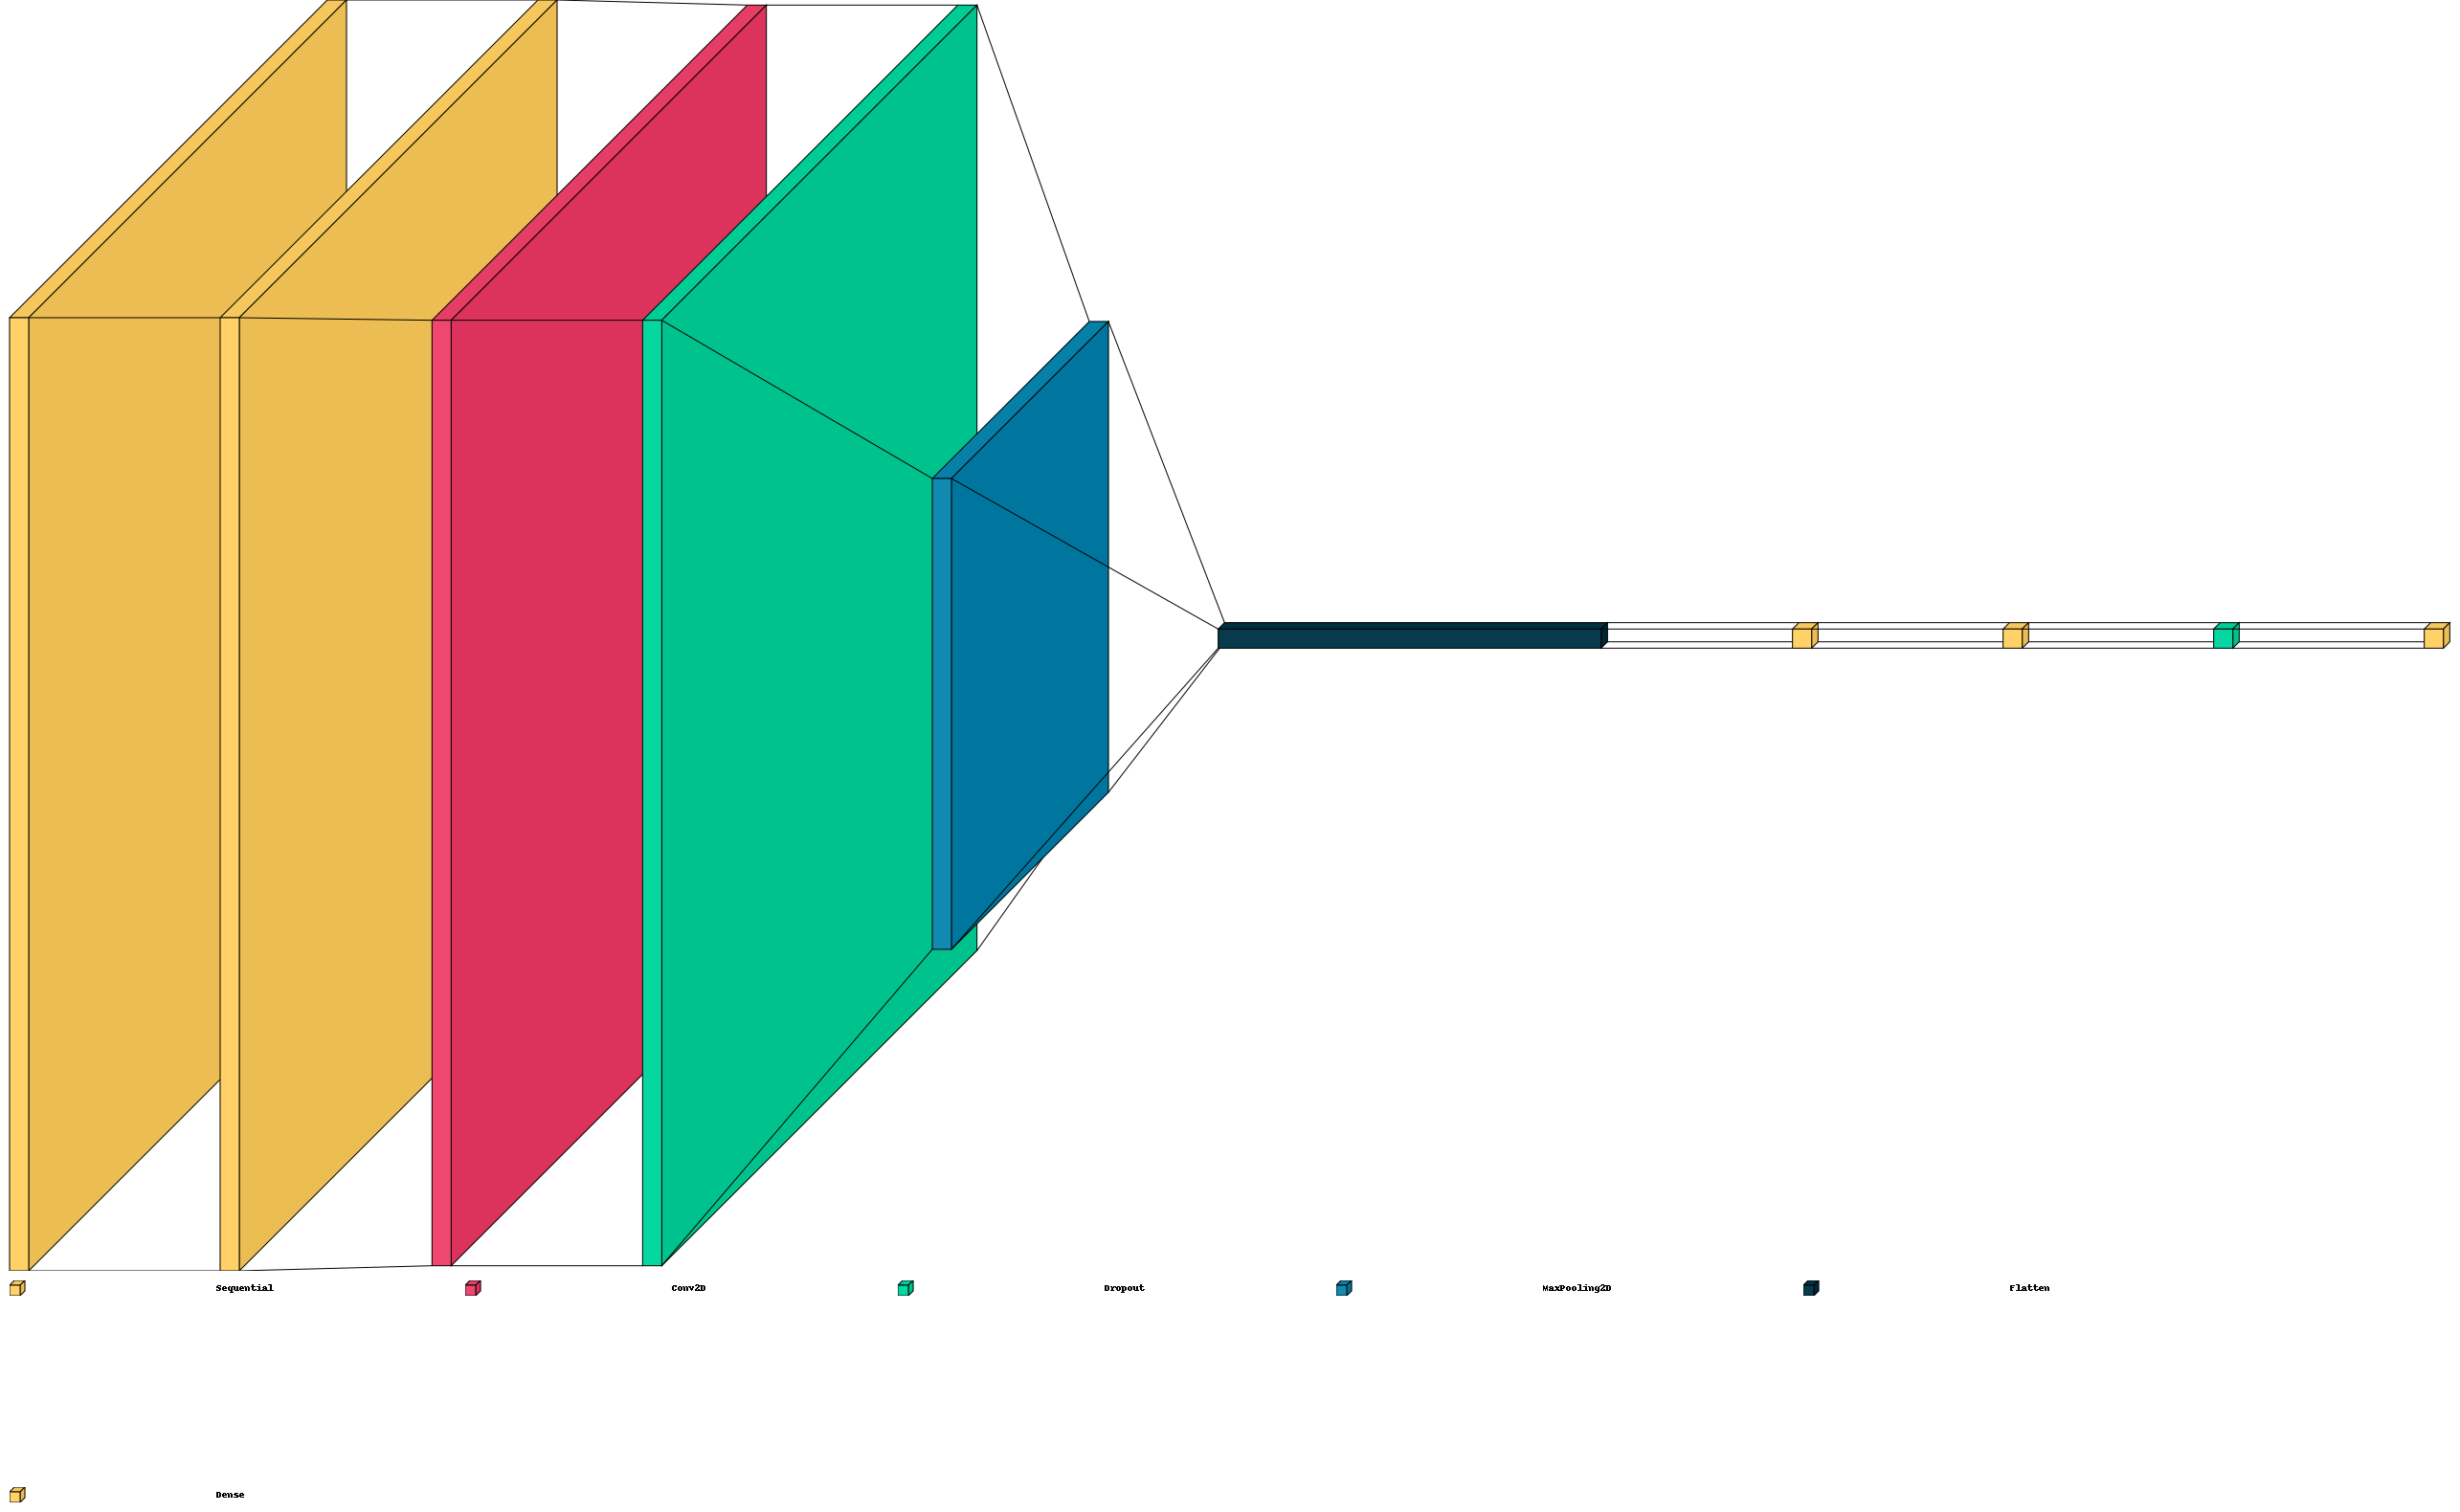

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 249, 249, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 249, 249, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 247, 247, 32)      896       
                                                                 
 dropout (Dropout)           (None, 247, 247, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 484128)            0         
                                                      

2023-08-09 12:25:46.176038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13125/13125 - 246s - loss: 0.2290 - accuracy: 0.9206 - val_loss: 0.1170 - val_accuracy: 0.9610 - 246s/epoch - 19ms/step
Epoch 2/20
13125/13125 - 238s - loss: 0.1342 - accuracy: 0.9564 - val_loss: 0.1239 - val_accuracy: 0.9612 - 238s/epoch - 18ms/step
Epoch 3/20
13125/13125 - 238s - loss: 0.1141 - accuracy: 0.9631 - val_loss: 0.0442 - val_accuracy: 0.9861 - 238s/epoch - 18ms/step
Epoch 4/20
13125/13125 - 236s - loss: 0.0984 - accuracy: 0.9680 - val_loss: 0.0492 - val_accuracy: 0.9842 - 236s/epoch - 18ms/step
Epoch 5/20
13125/13125 - 237s - loss: 0.0908 - accuracy: 0.9708 - val_loss: 0.0520 - val_accuracy: 0.9850 - 237s/epoch - 18ms/step
Epoch 6/20
13125/13125 - 237s - loss: 0.0996 - accuracy: 0.9689 - val_loss: 0.0828 - val_accuracy: 0.9768 - 237s/epoch - 18ms/step
Epoch 7/20
13125/13125 - 237s - loss: 0.0918 - accuracy: 0.9702 - val_loss: 0.0716 - val_accuracy: 0.9819 - 237s/epoch - 18ms/step
Epoch 8/20
13125/13125 - 240s - loss: 0.1061 - accuracy: 0.9697 - val_loss: 0.0798 - val_accur

**Train Accuracy = 96.31% - Validation Accuracy = 98.61% - Duration = 1960.37**

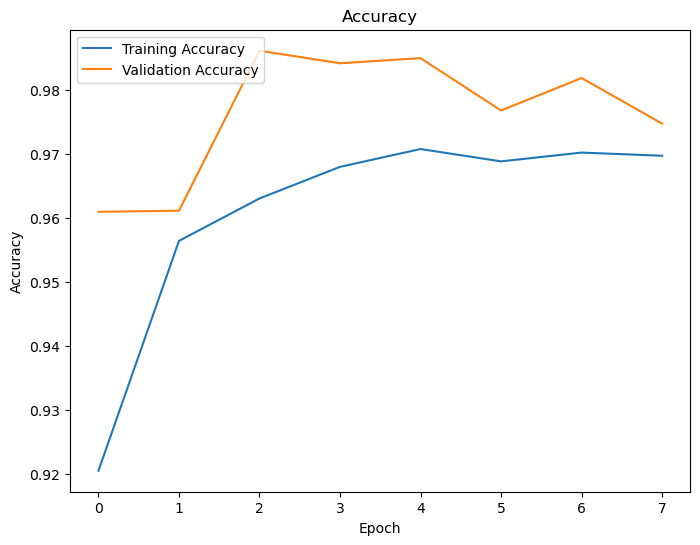

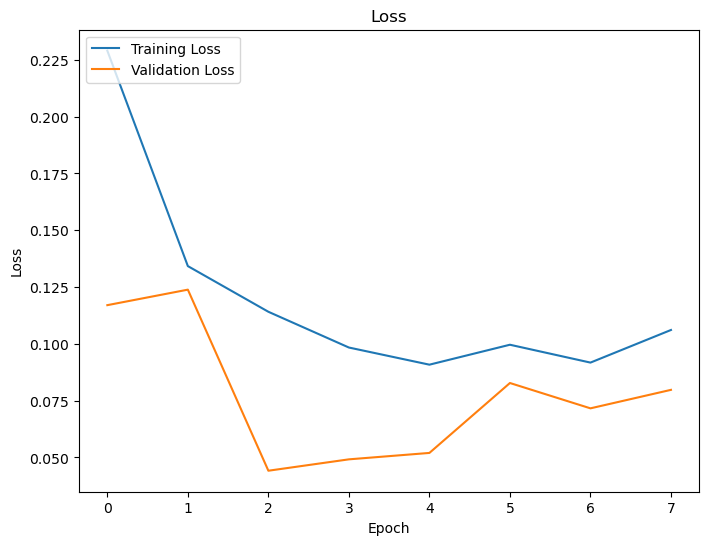

None

In [16]:
# Logs and models dir
# ----
mkdir(logs_path)
mkdir(best_model_path)

# ModelPerformanceReport
# ----
versions = list(models.keys())
report = ModelMetrics(versions)

# Get the shape
# ----
lx,ly, lz = image_shape

# Each model
# ----
for version, function in models.items():
    show_text("sep")
    show_text("h3","Run model {}".format(version))

    # Try model
    # ----
    try:
        # Get function by name
        # ----
        function = globals()[function]

        model = function(lx,ly,lz, preprocessings_layers)

        # Show it
        # ----
        display(layered_view(model, legend = True, spacing = 200))
        model.summary()

        # Callbacks bestmodel
        # ----
        filepath = f'{best_model_path}/model_{version}.h5'
        bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath  = filepath,
            verbose   = 0,
            monitor   = 'val_accuracy',
            save_best_only = True
        )
        report.add_best_model_path(version, filepath)

        # Callbacks EarlyStopping
        # ----
        earlystopping_callback = tf.keras.callbacks.EarlyStopping(
          monitor     = 'val_accuracy',
          min_delta   = 0,
          patience    = 5,
          verbose     = 0,
          mode        = 'auto',
          baseline    = None,
          restore_best_weights = True
        )

        # Time Start
        # ----
        report.start_timer(version)

        # Compile
        # ----
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Train
        # ----
        history = model.fit(
            x = train_ds,
            validation_data = val_ds,
            epochs = epochs,
            shuffle= True,
            verbose = verbosity,
            callbacks = [bestmodel_callback, earlystopping_callback]
        )
        # Time End
        # ----
        report.stop_timer(version)

        # Save history
        # ----
        report.add_history(version, history)

        # Show result
        # ----
        report.show_best_result(version)

        # Show history
        # ----
        report.show_history(version)

        # Clean for next
        # ----
        model = None
        history = None

    except Exception as e:
        print('An error occured for :',version, ' Error:', str(e))

report.show_report()

# <b>8 <span style='color:#78D118'>|</span> Model Evaluation</b>

After we have trained and optimized our machine learning model, the next important step is to evaluate its performance. This step helps us understand how well our model is performing.

We will utilize a confusion matrix, which provides a visual representation of the model's performance and allows us to observe the types of errors made by our model.

In [17]:
best_model_path = report.get_best_model_path()

model = load_model(best_model_path)

y_test, y_pred = tf_predictions(test_ds, model, labels)

Predicting: 100%|██████████| 2813/2813 [03:00<00:00, 15.56batch/s]


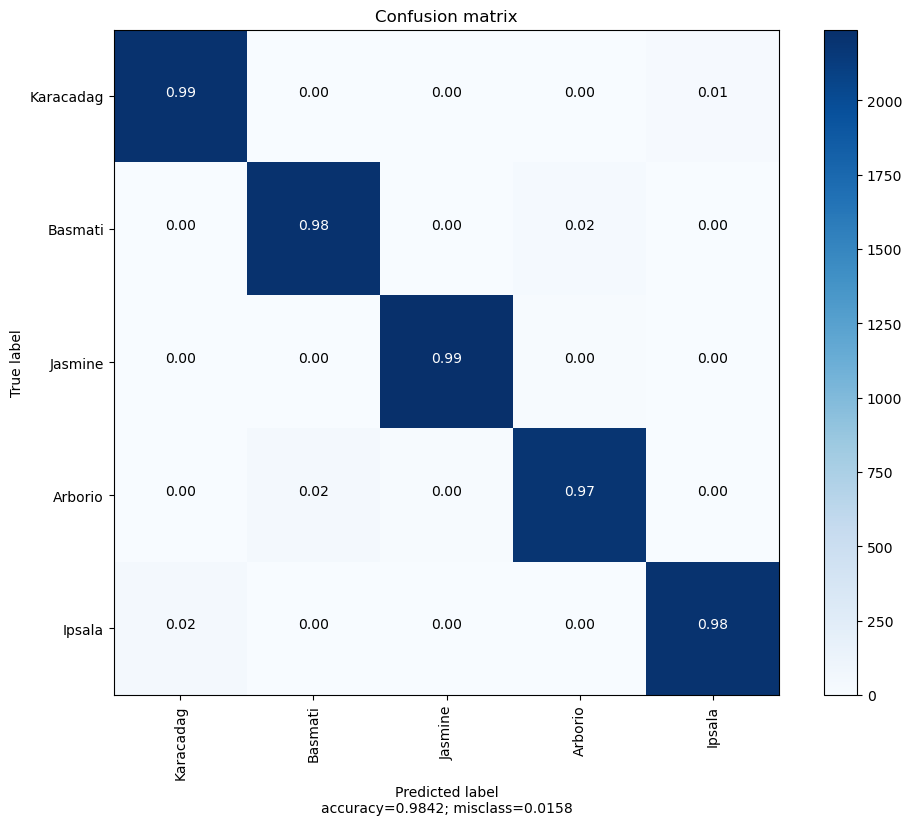

In [18]:
show_confusion_matrix(y_test, y_pred, labels=labels)

## <b>8.1. <span style='color:#78D118'>|</span> Previews</b>

In [19]:
test_ds = tf_shuffle_dataset(test_ds, 5, seed).take(40)
x_test, y_test, y_pred = tf_predictions(test_ds, model, labels, with_x_test=True)
x_test = rescale_preprocessing(x_test)

Predicting: 100%|██████████| 40/40 [00:42<00:00,  1.07s/batch]


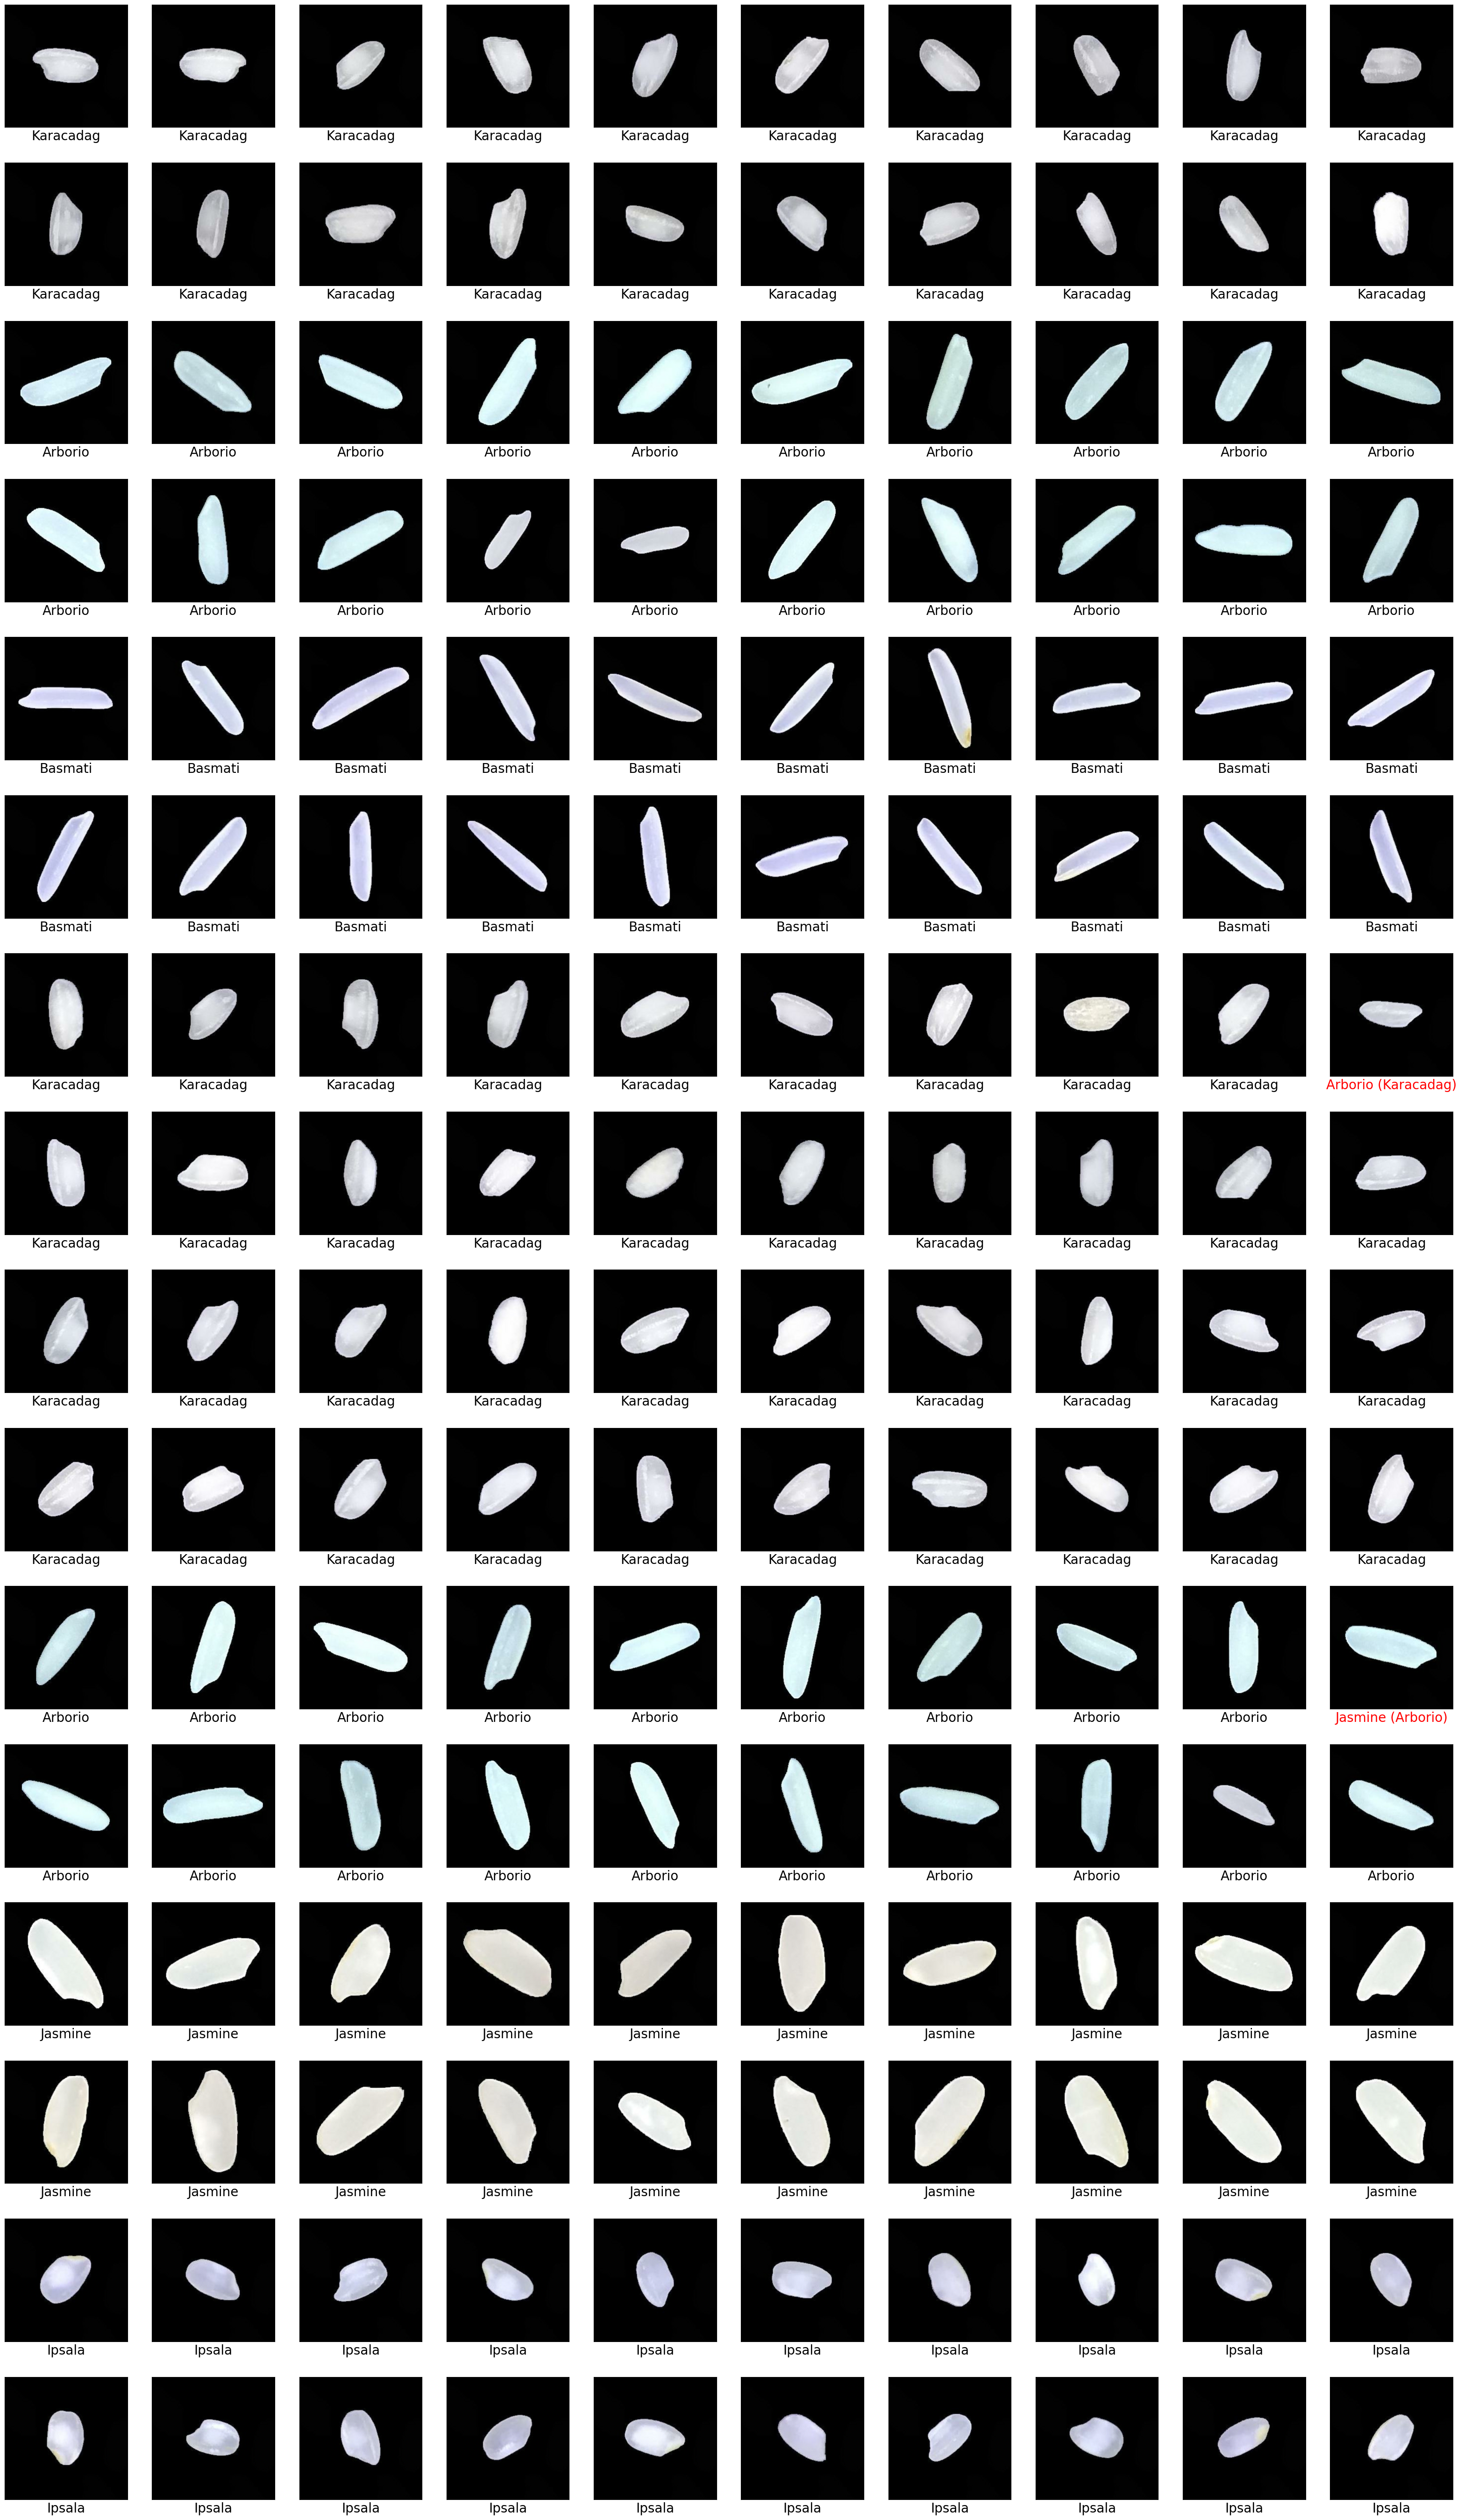

In [20]:
show_images(
    x_test,
    y_test,
    columns = 10,
    figure_size = (4,4),
    y_pred = y_pred
)

## <b>8.2. <span style='color:#78D118'>|</span> Previews wrong</b>

In [21]:
x_test, y_wrong, y_pred = tf_wrong_predictions(test_ds, model, labels, 20, with_x_test=True)
x_test = rescale_preprocessing(x_test)

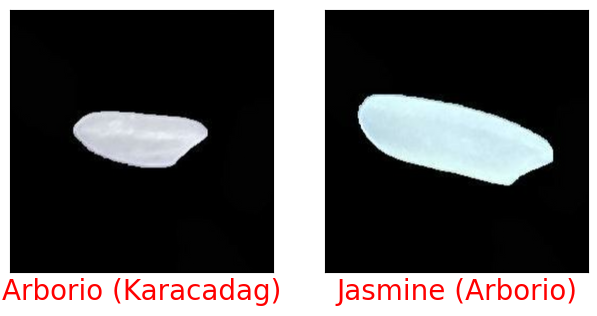

In [22]:
show_images(
    x_test,
    y_wrong,
    columns = 10,
    figure_size = (4,4),
    y_pred = y_pred
)